<a href="https://colab.research.google.com/github/Alizzie/ST_CA2/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alizzie/Data.git

Cloning into 'Data'...
remote: Enumerating objects: 33134, done.
remote: Total 33134 (delta 0), reused 0 (delta 0), pack-reused 33134
Receiving objects: 100% (33134/33134), 454.79 MiB | 17.89 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (33134/33134), done.


In [3]:
!ls

Data  sample_data


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [5]:
datadir = 'Data/DataTrack1'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
print(data.head)

<bound method NDFrame.head of                                                  center  \
0     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
1     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
2     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
3     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
4     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
...                                                 ...   
8316  C:\Users\elisa\OneDrive - hochschule-trier.de\...   
8317  C:\Users\elisa\OneDrive - hochschule-trier.de\...   
8318  C:\Users\elisa\OneDrive - hochschule-trier.de\...   
8319  C:\Users\elisa\OneDrive - hochschule-trier.de\...   
8320  C:\Users\elisa\OneDrive - hochschule-trier.de\...   

                                                   left  \
0     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
1     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
2     C:\Users\elisa\OneDrive - hochschule-trier.de\...   
3     C:\Users\elisa\OneD

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [7]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [8]:
print(data.head)

<bound method NDFrame.head of                                   center                              left  \
0     center_2023_12_30_22_17_33_627.jpg  left_2023_12_30_22_17_33_627.jpg   
1     center_2023_12_30_22_17_33_695.jpg  left_2023_12_30_22_17_33_695.jpg   
2     center_2023_12_30_22_17_33_779.jpg  left_2023_12_30_22_17_33_779.jpg   
3     center_2023_12_30_22_17_33_865.jpg  left_2023_12_30_22_17_33_865.jpg   
4     center_2023_12_30_22_17_33_936.jpg  left_2023_12_30_22_17_33_936.jpg   
...                                  ...                               ...   
8316  center_2023_12_30_22_34_01_654.jpg  left_2023_12_30_22_34_01_654.jpg   
8317  center_2023_12_30_22_34_01_724.jpg  left_2023_12_30_22_34_01_724.jpg   
8318  center_2023_12_30_22_34_01_809.jpg  left_2023_12_30_22_34_01_809.jpg   
8319  center_2023_12_30_22_34_01_875.jpg  left_2023_12_30_22_34_01_875.jpg   
8320  center_2023_12_30_22_34_02_041.jpg  left_2023_12_30_22_34_02_041.jpg   

                                 

In [9]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


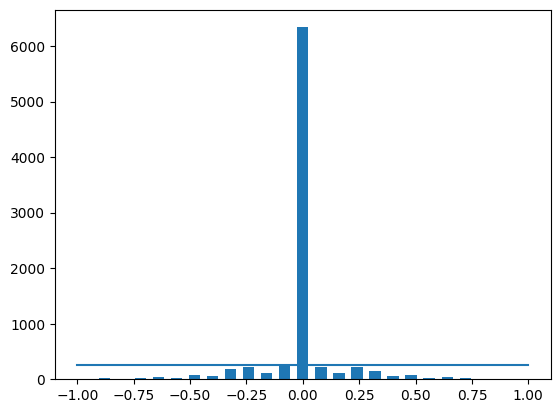

In [10]:
centre = (bins[:-1] + bins[1:])*0.5
samples_per_bin = 250
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [11]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if bins[j] <= data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)


In [12]:
print("Removed: ", len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print("Remaining: ", len(data))

Removed:  6086
Remaining:  2235


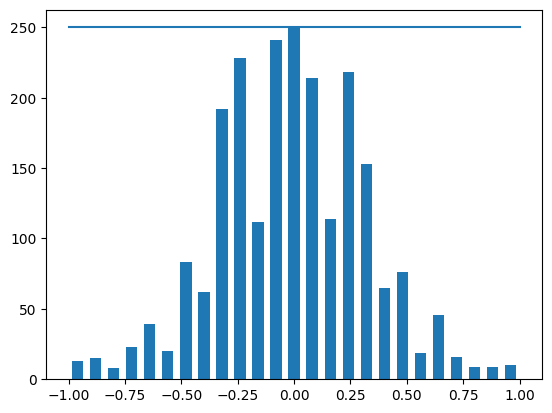

In [13]:
hist, bins = np.histogram(data['steering'], num_bins)
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [14]:
# Training and Validation split
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings


In [15]:
image_paths, steerings = load_img_steering(datadir+'/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [16]:
print(f"Traing samples {len(X_train)}, validation samples {len(X_valid)}")

Traing samples 1788, validation samples 447


Text(0.5, 1.0, 'Validation set')

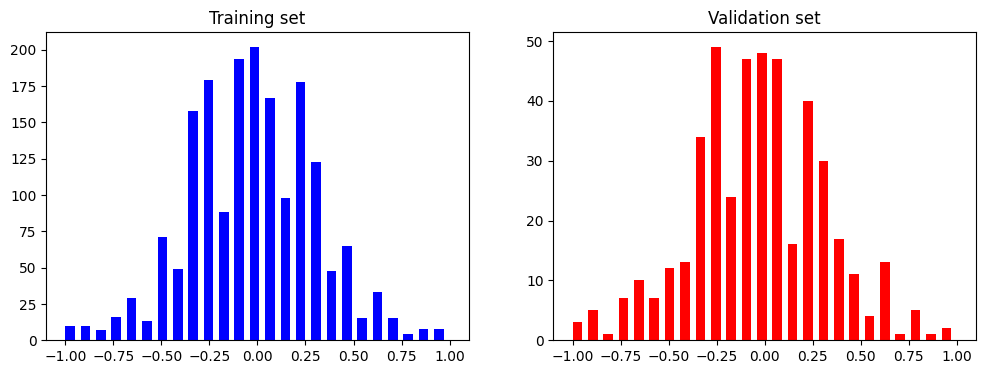

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins = num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [18]:
def zoom(img):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(img)
  return image

Text(0.5, 1.0, 'Zoomed image')

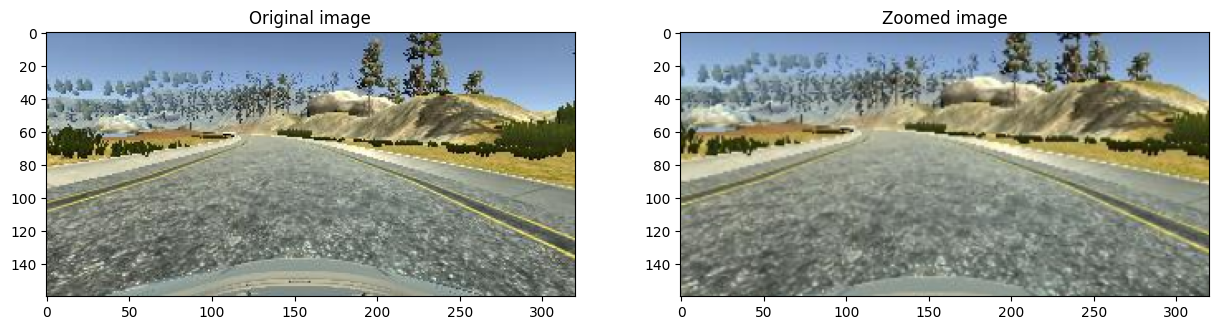

In [19]:
image = image_paths[random.randint(0, 100)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[1].imshow(zoomed_image)
axes[1].set_title("Zoomed image")

In [20]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y":(-0.1, 0.1)})
  panned_image = pan.augment_image(image)
  return panned_image

Text(0.5, 1.0, 'Panned image')

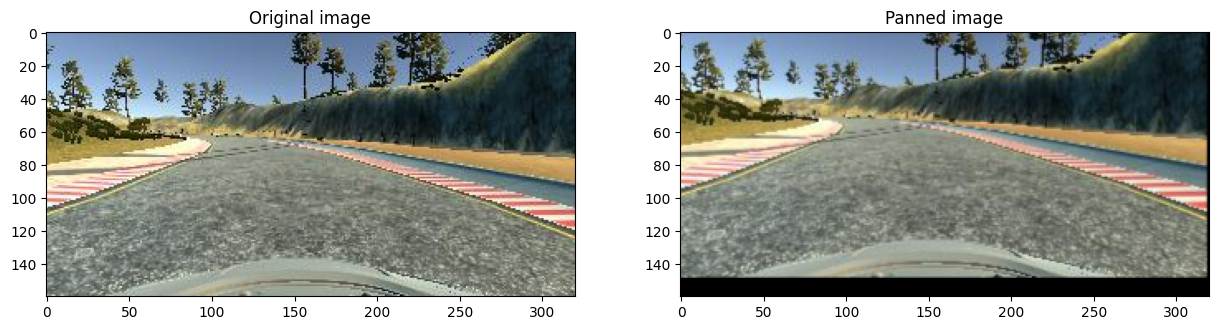

In [21]:
image = image_paths[random.randint(0, 100)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[1].imshow(panned_image)
axes[1].set_title("Panned image")

In [22]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brighten image')

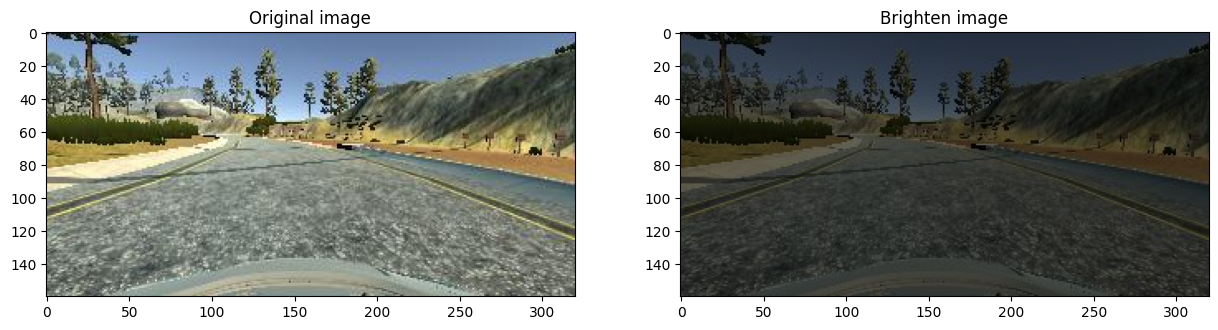

In [23]:
image = image_paths[random.randint(0, 100)]
original_image = mpimg.imread(image)
brighten_image = img_random_brightness(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[1].imshow(brighten_image)
axes[1].set_title("Brighten image")

In [24]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = - steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped image - Steering Angle: 0.25')

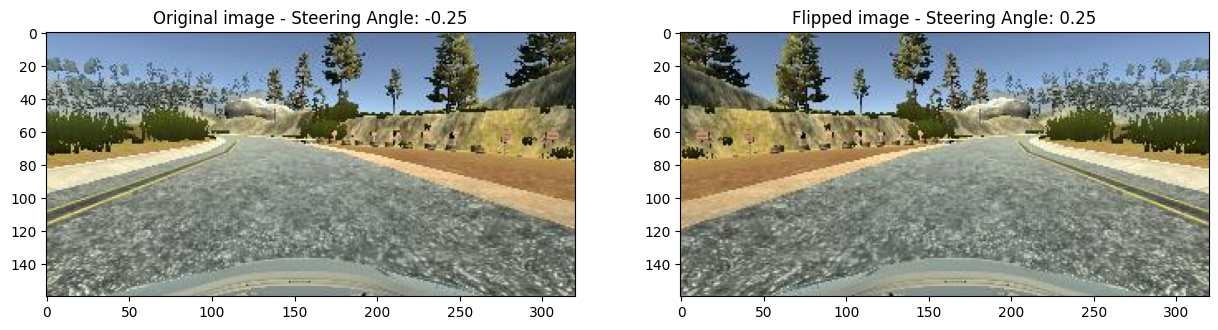

In [25]:
random_index = random.randint(0, 100)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle  = img_random_flip(original_image, steering_angle)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image - " + "Steering Angle: " + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title("Flipped image - " + "Steering Angle: " + str(flipped_steering_angle))

In [26]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

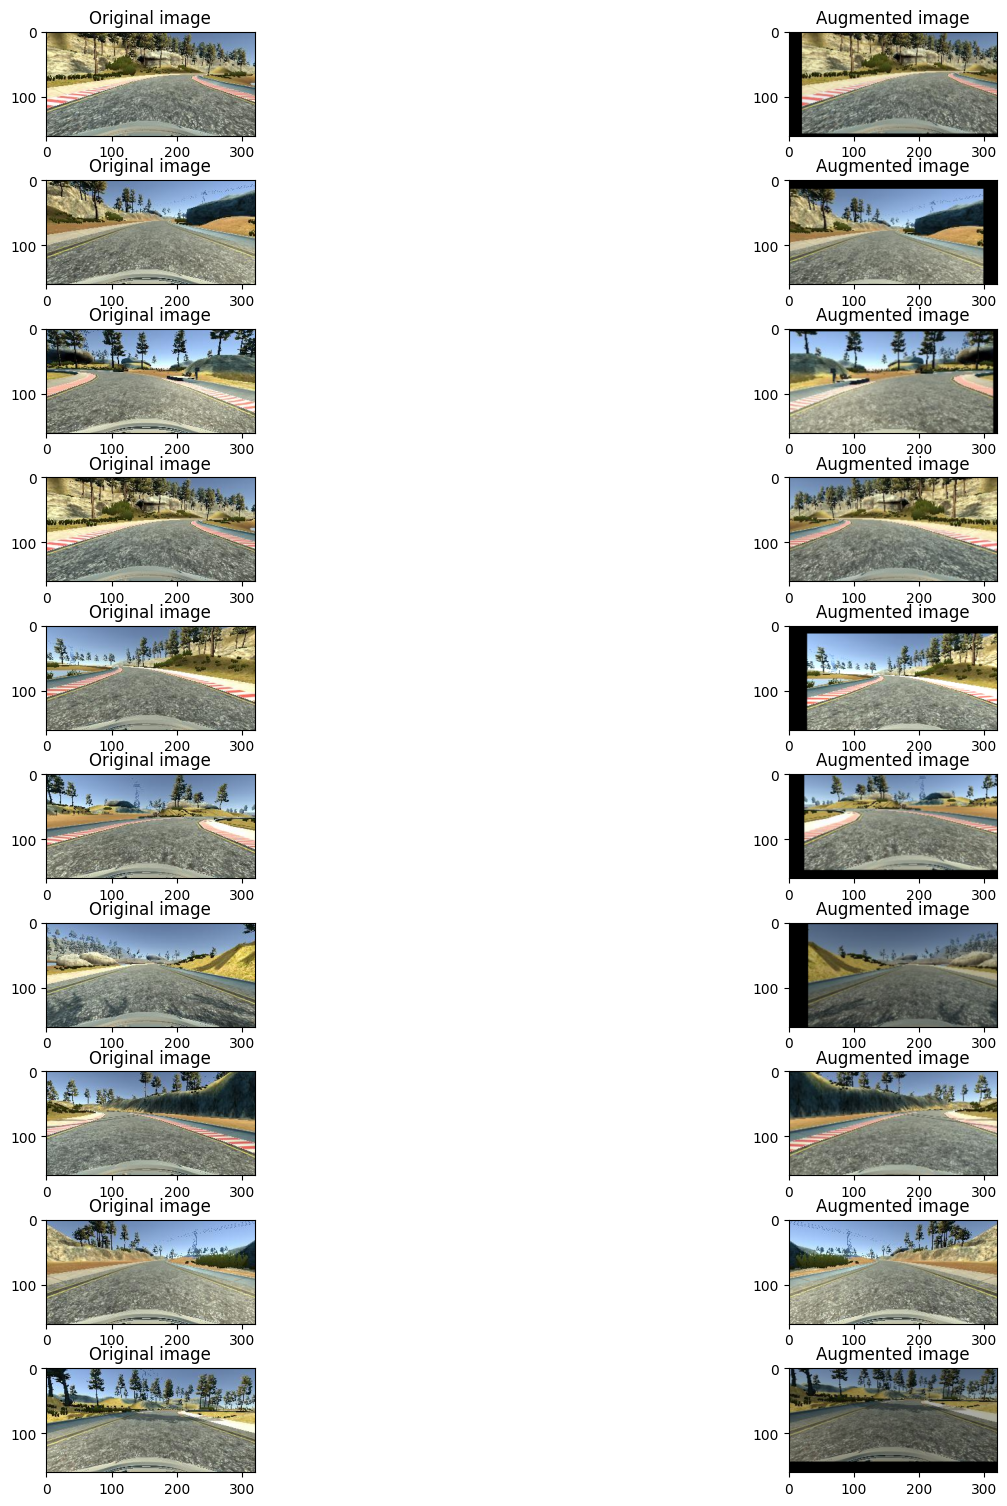

In [27]:
nrcols = 2
nrrows = 10
fig, axes = plt.subplots(nrrows, nrcols, figsize=(15, 15))
fig.tight_layout()
for i in range(10):
  rand_num = random.randint(0, len(image_paths)-1)
  random_image = image_paths[rand_num]
  random_steering = steerings[rand_num]
  original_image = mpimg.imread(random_image)
  augmented_image, steering_angle = random_augment(random_image, random_steering)
  axes[i][0].imshow(original_image)
  axes[i][0].set_title("Original image")
  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title("Augmented image")

In [28]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [29]:
def img_preprocess_no_imread(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [30]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      if is_training:
        img, steering = random_augment(image_paths[random_index], steering_angles[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_angles[random_index]
      img = img_preprocess_no_imread(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield(np.asarray(batch_img), np.asarray(batch_steering))


Text(0.5, 1.0, 'Preprocessed Image')

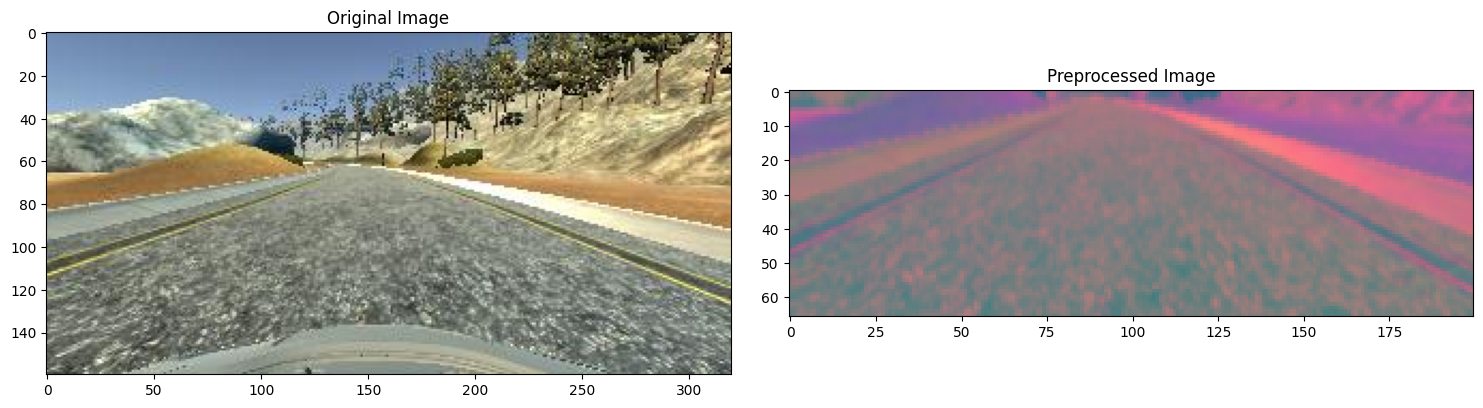

In [31]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("Preprocessed Image")


In [32]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [36]:
# https://arxiv.org/pdf/1604.07316v1.pdf
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(learning_rate = 0.001)
  model.compile(loss='mse', optimizer = optimizer, metrics=['mae'])
  return model


In [53]:
model = nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization_25 (Ba  (None, 31, 98, 24)        96        
 tchNormalization)                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_26 (Ba  (None, 14, 47, 36)        144       
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 batch_normalization_27 (Ba  (None, 5, 22, 48)        

In [55]:
history = model.fit(
    batch_generator(X_train, y_train, batch_size=200, is_training=1),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, batch_size=200, is_training=0),
    validation_steps=200,
    verbose=1,
    shuffle=True
)


Epoch 1/10
300/300 [==============================] - 287s 958ms/step - loss: 0.3664 - mae: 0.4227 - val_loss: 0.0815 - val_mae: 0.2099
Epoch 2/10
300/300 [==============================] - 249s 832ms/step - loss: 0.0893 - mae: 0.2280 - val_loss: 0.0605 - val_mae: 0.1790
Epoch 3/10
300/300 [==============================] - 264s 883ms/step - loss: 0.0695 - mae: 0.1997 - val_loss: 0.0542 - val_mae: 0.1665
Epoch 4/10
300/300 [==============================] - 239s 800ms/step - loss: 0.0622 - mae: 0.1881 - val_loss: 0.0508 - val_mae: 0.1645
Epoch 5/10
300/300 [==============================] - 237s 793ms/step - loss: 0.0580 - mae: 0.1817 - val_loss: 0.0476 - val_mae: 0.1631
Epoch 6/10
300/300 [==============================] - 239s 798ms/step - loss: 0.0541 - mae: 0.1761 - val_loss: 0.0478 - val_mae: 0.1635
Epoch 7/10
300/300 [==============================] - 263s 880ms/step - loss: 0.0525 - mae: 0.1733 - val_loss: 0.0478 - val_mae: 0.1595
Epoch 8/10
300/300 [============================

Text(0.5, 0, 'Epoch')

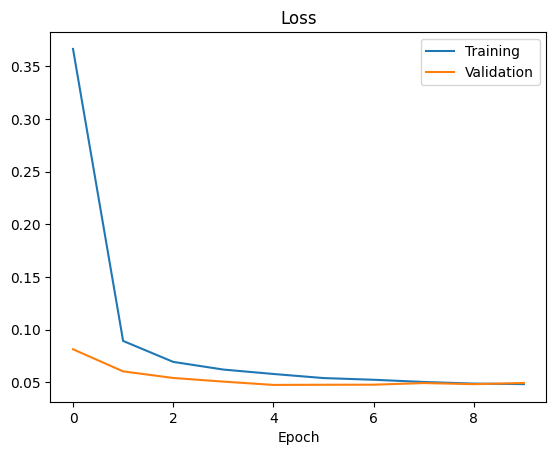

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [57]:
model.save('beta_model_epoch10_batch200_steps300.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
!ls
from google.colab import files
files.download('beta_model_epoch10_batch200_steps300.h5')

beta_model_epoch10_batch100_steps300.h5  beta_model_epoch10_batch64_steps300.h5   Data
beta_model_epoch10_batch200_steps300.h5  beta_model_epoch20_batch100_steps300.h5  sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>